In [1]:
import geojson
import geopandas as gpd
import pandas as pd 
from shapely.geometry import shape
import numpy as np
import json
from pyproj import Transformer, Geod
from wildfire.Reader import Reader as WFReader
import json, time
import requests



### City Information

In [2]:
DATA_FILENAME = 'data/geojson/USGS_Wildland_Fire_Combined_Dataset.json'
CITY_LOCATIONS = {
    'city'   : 'West Valley City',
    'latlon' : [40.69, -112.01],
    'fips': '18167',
    'county': 'Salt Lake',
    'state': 'Utah'

}

### API Configuration

In [3]:
#########
#
#    CONSTANTS
#

#
#    This is the root of all AQS API URLs
#
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

#
#    These are some of the 'actions' we can ask the API to take or requests that we can make of the API
#
#    Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'
#
#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
#
#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
#
#
#    This is a template that covers most of the parameters for the actions we might take, from the set of actions
#    above. In the examples below, most of the time parameters can either be supplied as individual values to a
#    function - or they can be set in a copy of the template and passed in with the template.
# 
AQS_REQUEST_TEMPLATE = {
    "email":      "",     
    "key":        "",      
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}


### Key Manager

In [4]:
#
#   Once we have the signup email, we can define two constants:
#
#   USERNAME - This should be the email address you sent the EPA asking for access to the API during sign-up
#   APIKEY   - This should be the authorization key they sent you
#
#   In this case I don't want to distribute my keys with the source of the notebook, so I wrote a key manager object that
#   helps track all of my API keys - a username and domain name retrieves the key. The key manager hides the keys on disk
#   separate from the code. Another common approach is to store your API key as an OS environment variable. You then use
#   a python package to extract that API key from the specific environment variable.
#
from apikeys.KeyManager import KeyManager
keyman = KeyManager()
#
#   Naturally, you should probably use the USERNAME that you used when you requested the API Key. I've used my email
#   address as my USERNAME when I added the API Key to the Key manager. This will look it up for me.
USERNAME = "nguyenbh@uw.edu"
key_info = keyman.findRecord(USERNAME,API_REQUEST_URL)
APIKEY = key_info[0]['key']
print(key_info[0]['description'])


A key for the https://aqs.epa.gov/data/api API


### Read data

Read wildfire data using json formats

In [8]:
combine_data_path = 'data/geojson/USGS_Wildland_Fire_Combined_Dataset.json'
with open(combine_data_path) as f:
    geo_data = geojson.load(f)
geo_data.keys()

dict_keys(['displayFieldName', 'fieldAliases', 'geometryType', 'spatialReference', 'fields', 'features'])

The data has multiple nested dictionaries, so normalize to read all the columns

In [49]:
# Normalize and see all columns
gdf = pd.json_normalize(geo_data['features'])
gdf.columns = [col.split(".")[-1] for col in gdf.columns]
print(gdf.columns)
display(gdf.head())

Index(['OBJECTID', 'USGS_Assigned_ID', 'Assigned_Fire_Type', 'Fire_Year',
       'Fire_Polygon_Tier', 'Fire_Attribute_Tiers', 'GIS_Acres',
       'GIS_Hectares', 'Source_Datasets', 'Listed_Fire_Types',
       'Listed_Fire_Names', 'Listed_Fire_Codes', 'Listed_Fire_IDs',
       'Listed_Fire_IRWIN_IDs', 'Listed_Fire_Dates', 'Listed_Fire_Causes',
       'Listed_Fire_Cause_Class', 'Listed_Rx_Reported_Acres',
       'Listed_Map_Digitize_Methods', 'Listed_Notes', 'Processing_Notes',
       'Wildfire_Notice', 'Prescribed_Burn_Notice', 'Wildfire_and_Rx_Flag',
       'Overlap_Within_1_or_2_Flag', 'Circleness_Scale', 'Circle_Flag',
       'Exclude_From_Summary_Rasters', 'Shape_Length', 'Shape_Area', 'rings',
       'curveRings'],
      dtype='object')


,OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,...,Prescribed_Burn_Notice,Wildfire_and_Rx_Flag,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,rings,curveRings
0,1,1,Wildfire,1860,1,1 (1),3940.207089,1594.545237,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (1),...,Prescribed fire data in this dataset represent...,None,None,0.047590,NaN,No,64888.449849,1.594545e+07,"[[[-1883775.5960000008, 1194154.1922999993], [...",NaN
1,2,2,Wildfire,1860,1,1 (1),772.518249,312.627044,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (1),...,Prescribed fire data in this dataset represent...,None,None,0.071367,NaN,No,23462.288613,3.126270e+06,"[[[-1887470.1312000006, 1187759.2441000007], [...",NaN
2,3,3,Wildfire,1860,1,1 (1),333.020409,134.768578,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (1),...,Prescribed fire data in this dataset represent...,None,None,0.379578,NaN,No,6679.573569,1.347686e+06,"[[[-1889386.1190000009, 1190683.9283000007], [...",NaN
3,4,4,Wildfire,1870,1,"1 (1), 3 (1)",22294.993577,9022.463795,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (1)",...,Prescribed fire data in this dataset represent...,None,None,0.158038,NaN,No,84700.719226,9.022464e+07,"[[[-1428896.2971, 864980.0340999998], [-142869...",NaN
4,5,5,Wildfire,1870,1,"1 (1), 3 (1)",36.985574,14.967531,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (1)",...,Prescribed fire data in this dataset represent...,None,None,0.218009,NaN,No,2937.265383,1.496753e+05,"[[[-1371410.4136999995, 595942.3960999995], [-...",NaN


Use wfreader class to read in the data and use its iterator to process all the features

In [10]:
#
#    This bit of code opens a new wildfire reader, gets the header information and prints it to the screen
#
print(f"Attempting to open '{DATA_FILENAME}' with wildfire.Reader() object")
wfreader = WFReader(DATA_FILENAME)
print()
#
#    Now print the header - it contains some useful information
#
header_dict = wfreader.header()
header_keys = list(header_dict.keys())
print("The header has the following keys:")
print(header_keys)
print()
print("Header Dictionary")
print(json.dumps(header_dict,indent=4))


Attempting to open 'data/geojson/USGS_Wildland_Fire_Combined_Dataset.json' with wildfire.Reader() object

The header has the following keys:
['displayFieldName', 'fieldAliases', 'geometryType', 'spatialReference', 'fields']

Header Dictionary
{
    "displayFieldName": "",
    "fieldAliases": {
        "OBJECTID": "OBJECTID",
        "USGS_Assigned_ID": "USGS Assigned ID",
        "Assigned_Fire_Type": "Assigned Fire Type",
        "Fire_Year": "Fire Year",
        "Fire_Polygon_Tier": "Fire Polygon Tier",
        "Fire_Attribute_Tiers": "Fire Attribute Tiers",
        "GIS_Acres": "GIS_Acres",
        "GIS_Hectares": "GIS_Hectares",
        "Source_Datasets": "Source Datasets",
        "Listed_Fire_Types": "Listed Fire Types",
        "Listed_Fire_Names": "Listed Fire Names",
        "Listed_Fire_Codes": "Listed Fire Codes",
        "Listed_Fire_IDs": "Listed Fire IDs",
        "Listed_Fire_IRWIN_IDs": "Listed Fire IRWIN IDs",
        "Listed_Fire_Dates": "Listed Fire Dates",
        "

In [11]:
#
#   This sample code will load the whole sample
#
# MAX_FEATURE_LOAD = 100
feature_list = list()
feature_count = 0
# A rewind() on the reader object makes sure we're at the start of the feature list
# This way, we can execute this cell multiple times and get the same result 
wfreader.rewind()
# Now, read through each of the features, saving them as dictionaries into a list
feature = wfreader.next()
while feature:
    feature_list.append(feature)
    feature_count += 1
    # if we're loading a lot of features, print progress
    if (feature_count % 100) == 0:
        print(f"Loaded {feature_count} features")
    # loaded the max we're allowed then break
    # if feature_count >= MAX_FEATURE_LOAD:
    #     break
    feature = wfreader.next()
#
#    Print the number of items (features) we think we loaded
print(f"Loaded a total of {feature_count} features")
#
#    Just a validation check - did all the items we loaded get into the list?
print(f"Variable 'feature_list' contains {len(feature_list)} features")




Loaded 100 features
Loaded 200 features
Loaded 300 features
Loaded 400 features
Loaded 500 features
Loaded 600 features
Loaded 700 features
Loaded 800 features
Loaded 900 features
Loaded 1000 features
Loaded 1100 features
Loaded 1200 features
Loaded 1300 features
Loaded 1400 features
Loaded 1500 features
Loaded 1600 features
Loaded 1700 features
Loaded 1800 features
Loaded 1900 features
Loaded 2000 features
Loaded 2100 features
Loaded 2200 features
Loaded 2300 features
Loaded 2400 features
Loaded 2500 features
Loaded 2600 features
Loaded 2700 features
Loaded 2800 features
Loaded 2900 features
Loaded 3000 features
Loaded 3100 features
Loaded 3200 features
Loaded 3300 features
Loaded 3400 features
Loaded 3500 features
Loaded 3600 features
Loaded 3700 features
Loaded 3800 features
Loaded 3900 features
Loaded 4000 features
Loaded 4100 features
Loaded 4200 features
Loaded 4300 features
Loaded 4400 features
Loaded 4500 features
Loaded 4600 features
Loaded 4700 features
Loaded 4800 features
L

### Compute distance between city locations to fire locations

#### Convert points between geodesic coordinate systems

In [13]:
#
#    Transform feature geometry data
#
#    The function takes one parameter, a list of ESRI:102008 coordinates that will be transformed to EPSG:4326
#    The function returns a list of coordinates in EPSG:4326
def convert_ring_to_epsg4326(ring_data=None):
    converted_ring = list()
    #
    # We use a pyproj transformer that converts from ESRI:102008 to EPSG:4326 to transform the list of coordinates
    to_epsg4326 = Transformer.from_crs("ESRI:102008","EPSG:4326")
    # We'll run through the list transforming each ESRI:102008 x,y coordinate into a decimal degree lat,lon
    for coord in ring_data:
        lat,lon = to_epsg4326.transform(coord[0],coord[1])
        new_coord = lat,lon
        converted_ring.append(new_coord)
    return converted_ring

#### Define functions to compute distance

In [30]:

#    
#    The function takes two parameters
#        A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#        Ring_data - a list of decimal degree coordinates for the fire boundary
#
#    The function returns a list containing the shortest distance to the perimeter and the point where that is
#
def shortest_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)    
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    closest_point = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        # convert the distance to miles
        distance_in_miles = d[2]*0.00062137
        # if it's closer to the city than the point we have, save it
        if not closest_point:
            closest_point.append(distance_in_miles)
            closest_point.append(point)
        elif closest_point and closest_point[0]>distance_in_miles:
            closest_point = list()
            closest_point.append(distance_in_miles)
            closest_point.append(point)
    return closest_point



#    
#    The function takes two parameters
#        A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#        Ring_data - a list of decimal degree coordinates for the fire boundary
#
#    The function returns the average miles from boundary to the place
#
def average_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)    
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    # create a list to store our results
    distances_in_meters = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        distances_in_meters.append(d[2])
    #print("Got the following list:",distances_in_meters)
    # convert meters to miles
    distances_in_miles = [meters*0.00062137 for meters in distances_in_meters]
    # the esri polygon shape (the ring) requires that the first and last coordinates be identical to 'close the region
    # we remove one of them so that we don't bias our average by having two of the same point
    distances_in_miles_no_dup = distances_in_miles[1:]
    # now, average miles
    if len(distances_in_miles_no_dup) == 0:
        return None
    average = sum(distances_in_miles_no_dup)/len(distances_in_miles_no_dup)
    return average



#### Compute distance

In [31]:
import pandas as pd

place = CITY_LOCATIONS
fires = []
batch_size = 1000  # Save the data as batches of 1,000 entries
file_count = 0
errors = []

for i, wf_feature in enumerate(feature_list):
    file_count += 1
    wf_year = wf_feature['attributes']['Fire_Year']
    if wf_year < 1964 or wf_year > 2024:
        continue    
    wf_name = wf_feature['attributes']['Listed_Fire_Names'].split(',')[0]
    wf_size = wf_feature['attributes']['GIS_Acres']
    wf_type = wf_feature['attributes']['Assigned_Fire_Type']
    if 'rings' in wf_feature['geometry']:
        ring_data = wf_feature['geometry']['rings'][0]
    elif 'curveRings' in wf_feature['geometry']:
        errors.append(i)
        continue # Skip over this polygon
        # ring_data = wf_feature['geometry']['curveRings'][0]
    else:
        raise Exception("No compatible geometry in this fire data!")
    
    distance = average_distance_from_place_to_fire_perimeter(place['latlon'], ring_data)
    
    if distance:
        fires.append({
            "Fire_Year": wf_year,
            "Fire_Name": wf_name,
            "GIS_Acres": wf_size,
            "Fire_Type": wf_type,
            "Distance": distance
        })
    
    # Save every 1,000 entries
    if (file_count + 1) % batch_size == 0:
        batch_path = f'data/fire_data/fire_distance_data_{file_count}.csv'
        pd.DataFrame(fires).to_csv(batch_path, index=False)
        fires = []  # Clear the list for the next batch
        print(f"Processing {i} files...")

# Save any remaining data
if fires:
    batch_path = f'data/fire_data/fire_distance_data_{file_count}.csv'
    pd.DataFrame(fires).to_csv(batch_path, index=False)

print("Intermediate files created.")

# Aggregating all batch files into a single CSV
distance_df = pd.concat(
    [pd.read_csv(f'data/fire_data/fire_distance_data_{i}.csv') for i in range(file_count + 1)],
    ignore_index=True
)
distance_df.to_csv('data/intermediate/fire_distance_data.csv', index=False)
print("Aggregated CSV saved.")


Intermediate files created.
Aggregated CSV saved.


In [38]:
distance_df

,Fire_Year,Fire_Name,GIS_Acres,Fire_Type,Distance
0,1964,COYOTE (4),65338.877636,Wildfire,597.497529
1,1964,C. HANLY (5),55960.694158,Wildfire,584.111579
2,1964,COZY DELL (5),19218.105903,Wildfire,531.527354
3,1964,HAYFORK HWY. #2 (5),18712.494746,Wildfire,574.839178
4,1964,MATTOLE (5),16887.001024,Wildfire,645.542020
...,...,...,...,...,...
117151,2020,WEW CA Broadcast (3),16.412148,Prescribed Fire,596.194054
117152,2020,2_PHMA_FIAT_Beulah_East_Bendire_NW_Malheur_Pri...,7.050837,Prescribed Fire,385.476773
117153,2020,2_PHMA_FIAT_Beulah_East_Bendire_NW_Malheur_Pri...,9.342668,Prescribed Fire,385.088504
117154,2020,2_WUI_Chicken Rx (1),0.996962,Prescribed Fire,167.677367


### Smoke Estimates

Filter the data to calculate smoke estimates. Only consider those fires within 650 miles for smoke estimates.

In [40]:
near_fires = distance_df[distance_df['Distance'] < 650]
# near_fires.to_csv('data/intermediate/nearby_fires.csv', index=False)
near_fires

,Fire_Year,Fire_Name,GIS_Acres,Fire_Type,Distance
0,1964,COYOTE (4),65338.877636,Wildfire,597.497529
1,1964,C. HANLY (5),55960.694158,Wildfire,584.111579
2,1964,COZY DELL (5),19218.105903,Wildfire,531.527354
3,1964,HAYFORK HWY. #2 (5),18712.494746,Wildfire,574.839178
4,1964,MATTOLE (5),16887.001024,Wildfire,645.542020
...,...,...,...,...,...
117151,2020,WEW CA Broadcast (3),16.412148,Prescribed Fire,596.194054
117152,2020,2_PHMA_FIAT_Beulah_East_Bendire_NW_Malheur_Pri...,7.050837,Prescribed Fire,385.476773
117153,2020,2_PHMA_FIAT_Beulah_East_Bendire_NW_Malheur_Pri...,9.342668,Prescribed Fire,385.088504
117154,2020,2_WUI_Chicken Rx (1),0.996962,Prescribed Fire,167.677367


Compute the smoke for each fire by dividing the burned acres by the distance.

In [41]:
near_fires['smoke'] = near_fires['GIS_Acres']/near_fires['Distance']
near_fires

C:\Users\nguye\AppData\Local\Temp\ipykernel_82160\1498582562.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  near_fires['smoke'] = near_fires['GIS_Acres']/near_fires['Distance']


,Fire_Year,Fire_Name,GIS_Acres,Fire_Type,Distance,smoke
0,1964,COYOTE (4),65338.877636,Wildfire,597.497529,109.354222
1,1964,C. HANLY (5),55960.694158,Wildfire,584.111579,95.804802
2,1964,COZY DELL (5),19218.105903,Wildfire,531.527354,36.156382
3,1964,HAYFORK HWY. #2 (5),18712.494746,Wildfire,574.839178,32.552574
4,1964,MATTOLE (5),16887.001024,Wildfire,645.542020,26.159414
...,...,...,...,...,...,...
117151,2020,WEW CA Broadcast (3),16.412148,Prescribed Fire,596.194054,0.027528
117152,2020,2_PHMA_FIAT_Beulah_East_Bendire_NW_Malheur_Pri...,7.050837,Prescribed Fire,385.476773,0.018291
117153,2020,2_PHMA_FIAT_Beulah_East_Bendire_NW_Malheur_Pri...,9.342668,Prescribed Fire,385.088504,0.024261
117154,2020,2_WUI_Chicken Rx (1),0.996962,Prescribed Fire,167.677367,0.005946


#### Compute cummulative smoke estimates

I decided to compute cummulative smoke estimates by summing all smoke for each year and carrying 20% from the last year to current estimates.
Because from my understanding, most of the smoke dissipates over time, but there'll be some lingering. For the worst case, I define the carry over factor to be 20%.

In [44]:
# Ensure data is sorted by year
near_fires = near_fires.sort_values(by='Fire_Year')
near_fires

# Calculate cumulative smoke each year
annual_smoke = {}
carryover_factor = 0.2  # percentage of smoke carryover to the next year

for year in near_fires['Fire_Year'].unique():
    # Sum smoke for the current year
    yearly_smoke = near_fires[near_fires['Fire_Year'] == year]['smoke'].sum()
    
    # Apply 80% of the previous year's cumulative smoke, if any
    previous_year_smoke = annual_smoke.get(year - 1, 0)
    cumulative_smoke = yearly_smoke + (carryover_factor * previous_year_smoke)
    
    # Store the cumulative smoke estimate for the current year
    annual_smoke[year] = cumulative_smoke

# Convert results to a DataFrame for better visualization
cumulative_smoke_df = pd.DataFrame(list(annual_smoke.items()), columns=['year', 'cumulative_smoke'])
print(cumulative_smoke_df)
# cumulative_smoke_df.to_csv('data/intermediate/cumulative_smoke.csv', index=False)


    Year  Cumulative_Smoke
0   1964       1075.820025
1   1965        710.245794
2   1966       2615.136579
3   1967       1455.560877
4   1968        970.818183
5   1969        789.169920
6   1970       1856.734507
7   1971       2727.490388
8   1972       1551.947105
9   1973       2306.003100
10  1974       1664.370376
11  1975       1323.504304
12  1976       2007.635292
13  1977       1578.063821
14  1978        798.263644
15  1979       2397.290929
16  1980       2563.021354
17  1981       5858.117480
18  1982       3107.724593
19  1983       6752.028989
20  1984       5209.037977
21  1985       9509.817498
22  1986       7955.576276
23  1987       6876.208743
24  1988      13686.350278
25  1989       5837.508050
26  1990       4202.362134
27  1991       2652.982321
28  1992       5931.490088
29  1993       3029.748412
30  1994      10570.401642
31  1995       8443.472990
32  1996      21345.517366
33  1997       5890.943479
34  1998       5803.875451
35  1999      15574.011932
3

### Predictive model
Build a predictive model to predict smoke estimates for every year in the future until 2050.

R-squared: 0.555326902849287


c:\Users\nguye\anaconda3\envs\data512_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


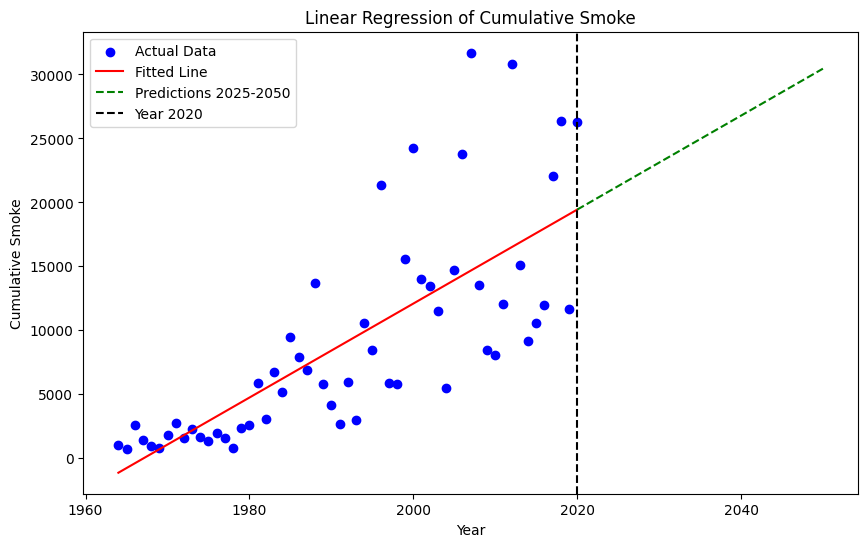

In [46]:
import numpy as np
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

# Prepare the data
X = cumulative_smoke_df[['Year']]
y = cumulative_smoke_df['Cumulative_Smoke']

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Print R-squared
r_squared = model.score(X, y)
print(f"R-squared: {r_squared}")

# Predict future values from 2025 to 2050
future_years = np.arange(2020, 2051).reshape(-1, 1)
future_predictions = model.predict(future_years)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Actual Data')
plt.plot(X, model.predict(X), color='red', label='Fitted Line')
plt.plot(future_years, future_predictions, color='green', linestyle='--', label='Predictions 2025-2050')

plt.axvline(x=2020, color='black', linestyle='--', label='Year 2020')
plt.xlabel('Year')
plt.ylabel('Cumulative Smoke')
plt.title('Linear Regression of Cumulative Smoke')
plt.legend()
plt.show()